# Import Data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import random

In [ ]:
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


In [ ]:
# Import Dataset_1 with 1868 users and 2770 artists
df = pd.read_csv('Dataset_1.csv')
print(len(df['userID'].unique()))
print(len(df['artistID'].unique()))
df

1868
2770


,userID,artistID,name,Label,IR,FriendsListening,FriendsRating
0,1734,462,Blue,1,0.042589,0,0
1,1671,2834,Lynyrd Skynyrd,1,0.115877,3,2
2,1519,2608,City and Colour,1,0.038584,0,0
3,776,2820,Sakura,0,0.003305,1,1
4,29,951,Bon Jovi,1,0.065713,0,0
...,...,...,...,...,...,...,...
80132,772,8258,Emil Bulls,1,0.000531,0,0
80133,780,4767,Aura Dione,0,0.002057,0,0
80134,409,1964,Deerhunter,0,0.025713,0,0
80135,1902,2572,Minus the Bear,0,0.014403,0,0


In [ ]:
# Import Dataset_2 with 
df2 = pd.read_csv('Dataset_2.csv')
print(len(df2['userID'].unique()))
print(len(df2['artistID'].unique()))
df2

1880
5426


,userID,artistID,name,Label,IR,FriendsListening,FriendsRating
0,853,5640,Nitrominds,0,0.002098,0,0
1,1275,7266,Pete Townshend,1,0.004690,0,0
2,1649,300,Katy Perry,1,1.440149,3,2
3,552,3440,Ween,0,0.000203,0,0
4,1707,1358,Judas Priest,1,0.087976,0,0
...,...,...,...,...,...,...,...
71425,467,7232,Jean-Jacques Goldman,1,0.038142,0,0
71426,229,1404,Lone,0,0.001262,0,0
71427,1625,2341,Twisted Sister,0,0.002150,0,0
71428,2013,15083,Mondo Grosso,0,0.002954,0,0


# Approach 1 (dataset_1 only IR feature)

In [ ]:
print(len(df.loc[df['Label'] == 1]))
print(len(df.loc[df['Label'] == 0]))

31349
48788


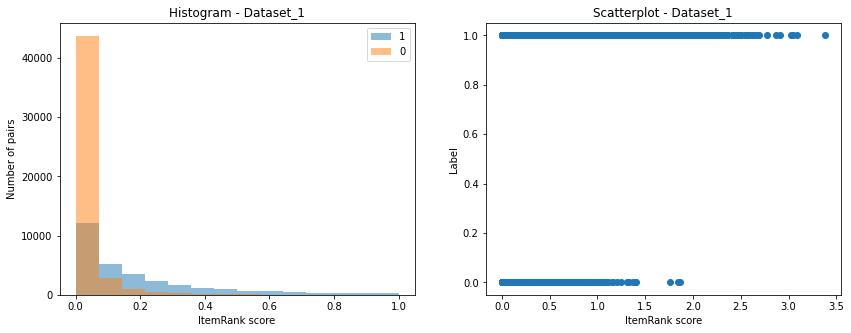

<function matplotlib.pyplot.tight_layout>

In [ ]:
#visualize data 
plt.figure(figsize=(14, 5)) 

plt.subplot(1,2,1)
bins = np.linspace(0, 1, 15)
plt.hist(df['IR'].loc[df['Label'] == 1].values,bins, alpha=0.5, label='1')
plt.hist(df['IR'].loc[df['Label'] == 0].values,bins, alpha=0.5, label='0')
plt.ylabel('Number of pairs')
plt.xlabel('ItemRank score')
plt.legend(loc='upper right')
plt.title('Histogram - Dataset_1')


plt.subplot(1,2,2)
plt.scatter(df['IR'].values, df['Label'].values)
plt.xlabel('ItemRank score')
plt.ylabel('Label')
plt.title('Scatterplot - Dataset_1')

plt.show()
plt.tight_layout

In [ ]:
# create X
X = np.array(df['IR'])
X.shape

(80137,)

In [ ]:
# create y
y = np.array(df['Label'])
y.shape

(80137,)

In [ ]:
# divide data into training and test split
X_train = X[:65000].reshape(-1, 1)
X_test = X[65000:].reshape(-1, 1)

y_train = y[:65000]
y_test = y[65000:]

## Logistic Regression

### Model Selection

In [ ]:
C_param_range = [0.001,0.01,0.1,1,10,100]

for c in C_param_range:

    model_LR = LogisticRegression(C = c)
    model_LR.fit(X_train, y_train)

    model_LR_mean_score = np.mean(cross_val_score(model_LR, X_train, y_train, cv=5))
    print('Mean cross validation score '+str(model_LR_mean_score ))

Mean cross validation score 0.6766923076923078
Mean cross validation score 0.7402615384615384
Mean cross validation score 0.7649230769230769
Mean cross validation score 0.7689230769230769
Mean cross validation score 0.7694923076923078
Mean cross validation score 0.7695846153846155


In [ ]:
model_LR = LogisticRegression()
# Fit model
model_LR.fit(X_train, y_train)
print("Traning accuracy for Linear Regression: {}".format(model_LR.score(X_train, y_train)))

Traning accuracy for Linear Regression: 0.7690769230769231


### Evaluation

Test score 0.769439122679527


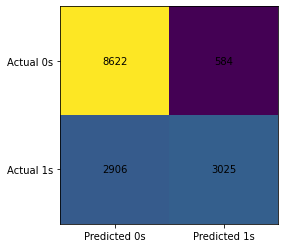

Sensitivity = 0.5100320350699713
Specificity = 0.9365631110145557


In [ ]:
# TEST DATA
# score
print('Test score '+str(model_LR.score(X_test, y_test) ))
# confusion matrix
cm = confusion_matrix(y_test, model_LR.predict(X_test))
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center')
plt.show()

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, model_LR.predict(X_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

In [ ]:
model_LR.predict_proba(X_test)[28] 

array([0.50711134, 0.49288866])

In [ ]:
model_LR.predict(X_test)[28] 

0

In [ ]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
LR_probs = model_LR.predict_proba(X_test)
# keep probabilities for the positive outcome only
LR_probs = LR_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
LR_auc = roc_auc_score(y_test, LR_probs)
# summarize scores
print('Logistic Regression: ROC AUC = %.3f' % (LR_auc))

Logistic Regression: ROC AUC = 0.843


## SVC

### Model Selection

In [ ]:
C_input = [0.1,1,10,100]
G_input = [0.01,0.1,'auto',10]
kernel_input = ['rbf', 'linear']
for i in range(len(C_input)):
    for j in range(len(G_input)):
        for k in range(len(kernel_input)):
            svc = svm.SVC(C=C_input[i], kernel=kernel_input[k], gamma=G_input[j])
            score = np.mean(cross_val_score(svc, X_train, y_train, cv=5))
            print('C:'+ str(C_input[i]) + ', gamma:'+ str(G_input[j]) +', kernel:'+ str(kernel_input[k]) +', score:'+str(score))

In [ ]:
C_input = [5,10]
G_input = ['auto',5]
kernel_input = 'rbf'
for i in range(len(C_input)):
      for j in range(len(G_input)):
        svc = svm.SVC(C=C_input[i], kernel=kernel_input, gamma=G_input[j])
        score = np.mean(cross_val_score(svc, X_train, y_train, cv=5))
        print('C:'+ str(C_input[i]) + ', gamma:'+ str(G_input[j]) +', score:'+str(score))

C:5, gamma:auto, score:0.7830461538461538
C:5, gamma:5, score:0.7847999999999999
C:10, gamma:auto, score:0.7836769230769229
C:10, gamma:5, score:0.7831230769230769


In [ ]:
# good enought for C=10, we don't want to overfit 
svc = svm.SVC(C=10, kernel='rbf', probability=True)
# fit model
svc.fit(X_train, y_train)
print("Traning accuracy for SVC: {}".format(svc.score(X_train, y_train)))

Traning accuracy for SVM: 0.7844769230769231


### Evaluation

Testing accuracy for SVC: 0.785162185373588


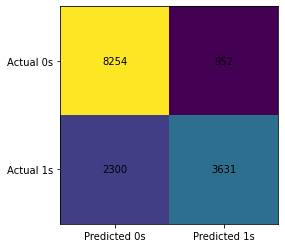

Sensitivity = 0.6122070477153937
Specificity = 0.8965891809689333


In [ ]:
# TEST DATA
# score
print('Testing accuracy for SVC: '+str(svc.score(X_test, y_test) ))
# confusion matrix
cm = confusion_matrix(y_test, svc.predict(X_test))
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center')
plt.show()

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, svc.predict(X_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

In [ ]:
svc.predict_proba(X_test)[72] 

array([0.55881809, 0.44118191])

In [ ]:
svc.predict(X_test)[72] 

0

In [ ]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
svc_probs = svc.predict_proba(X_test)
# keep probabilities for the positive outcome only
svc_probs = svc_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
svc_auc = roc_auc_score(y_test, svc_probs)
# summarize scores
print('SVC: ROC AUC = %.3f' % (svc_auc))

SVC: ROC AUC = 0.820


## Random Forest

### Model Selection

In [ ]:
N_input = [3,10,100,300,1000]
D_input = [3,10,20,40,100]
for i in range(len(N_input)):
    for j in range(len(D_input)):
        rfc = RandomForestClassifier(n_estimators=N_input[i], max_depth=D_input[j])
        score = np.mean(cross_val_score(rfc, X_train, y_train, cv=5))
        print('# estimators:'+ str(N_input[i]) + ', depth:'+ str(D_input[j]) +', score:'+str(score))

# estimators:3, depth:3, score:0.7867076923076923
# estimators:3, depth:10, score:0.7826615384615385
# estimators:3, depth:20, score:0.7596307692307693
# estimators:3, depth:40, score:0.7155230769230769
# estimators:3, depth:100, score:0.7050769230769232
# estimators:10, depth:3, score:0.7864307692307693
# estimators:10, depth:10, score:0.7854461538461538
# estimators:10, depth:20, score:0.7654615384615385
# estimators:10, depth:40, score:0.7127076923076923
# estimators:10, depth:100, score:0.7091846153846154
# estimators:100, depth:3, score:0.7869538461538462
# estimators:100, depth:10, score:0.7865076923076924
# estimators:100, depth:20, score:0.772123076923077
# estimators:100, depth:40, score:0.7084
# estimators:100, depth:100, score:0.7012615384615384
# estimators:300, depth:3, score:0.7867692307692308
# estimators:300, depth:10, score:0.7867230769230769
# estimators:300, depth:20, score:0.7724153846153846
# estimators:300, depth:40, score:0.7061230769230769
# estimators:300, dept

In [ ]:
N_input = [3,10,100,300,1000]
D_input = [1,2,3,5,8,10]
for i in range(len(N_input)):
    for j in range(len(D_input)):
        rfc = RandomForestClassifier(n_estimators=N_input[i], max_depth=D_input[j])
        score = np.mean(cross_val_score(rfc, X_train, y_train, cv=5))
        print('# estimators:'+ str(N_input[i]) + ', depth:'+ str(D_input[j]) +', score:'+str(score))

# estimators:3, depth:1, score:0.7861846153846154
# estimators:3, depth:2, score:0.7861076923076922
# estimators:3, depth:3, score:0.7865076923076924
# estimators:3, depth:5, score:0.7868153846153847
# estimators:3, depth:8, score:0.7849384615384616
# estimators:3, depth:10, score:0.7827846153846154
# estimators:10, depth:1, score:0.786676923076923
# estimators:10, depth:2, score:0.7866923076923078
# estimators:10, depth:3, score:0.7868615384615385
# estimators:10, depth:5, score:0.7872307692307692
# estimators:10, depth:8, score:0.7864461538461539
# estimators:10, depth:10, score:0.785723076923077
# estimators:100, depth:1, score:0.786676923076923
# estimators:100, depth:2, score:0.786676923076923
# estimators:100, depth:3, score:0.7868769230769231
# estimators:100, depth:5, score:0.7867076923076922
# estimators:100, depth:8, score:0.7868307692307692
# estimators:100, depth:10, score:0.7868461538461539
# estimators:300, depth:1, score:0.7866615384615384
# estimators:300, depth:2, scor

In [ ]:
rfc = RandomForestClassifier(n_estimators=10, max_depth=3)
rfc.fit(X_train, y_train)

print("Traning accuracy for Random Forest: {}".format(rfc.score(X_train, y_train)))

Traning accuracy for Random Forest: 0.7873230769230769


### Evaluation

Testing accuracy for RFC: 0.7868137675893506


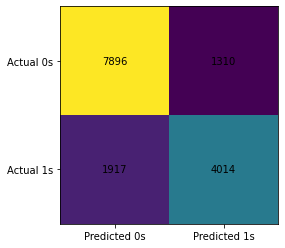

Sensitivity = 0.6767830045523521
Specificity = 0.8577014990223767


In [ ]:
# TEST DATA
# score
print('Testing accuracy for RFC: '+str(rfc.score(X_test, y_test) ))
# confusion matrix
cm = confusion_matrix(y_test, rfc.predict(X_test))
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center')
plt.show()

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, rfc.predict(X_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

In [ ]:
rfc.predict_proba(X_test)[6] 

array([0.49412512, 0.50587488])

In [ ]:
rfc.predict(X_test)[6] 

1

In [ ]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
rfc_probs = rfc.predict_proba(X_test)
# keep probabilities for the positive outcome only
rfc_probs = rfc_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
rfc_auc = roc_auc_score(y_test, rfc_probs)
# summarize scores
print('RFC: ROC AUC = %.3f' % (rfc_auc))

RFC: ROC AUC = 0.842


## Comparison

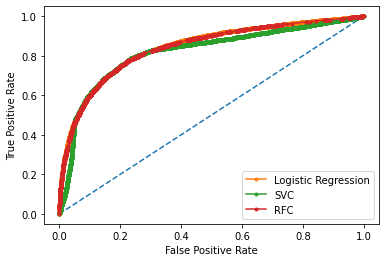

In [ ]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
LR_fpr, LR_tpr, _ = roc_curve(y_test, LR_probs)
rfc_fpr, rfc_tpr, _ = roc_curve(y_test, rfc_probs)
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(LR_fpr, LR_tpr, marker='.', label='Logistic Regression')
plt.plot(svc_fpr, svc_tpr, marker='.', label='SVC')
plt.plot(rfc_fpr, rfc_tpr, marker='.', label='RFC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


# Approach 2 ( dataset_1  + user friends feature)

In [ ]:
df

,userID,artistID,name,Label,IR,FriendsListening,FriendsRating
0,1734,462,Blue,1,0.042589,0,0
1,1671,2834,Lynyrd Skynyrd,1,0.115877,3,2
2,1519,2608,City and Colour,1,0.038584,0,0
3,776,2820,Sakura,0,0.003305,1,1
4,29,951,Bon Jovi,1,0.065713,0,0
...,...,...,...,...,...,...,...
80132,772,8258,Emil Bulls,1,0.000531,0,0
80133,780,4767,Aura Dione,0,0.002057,0,0
80134,409,1964,Deerhunter,0,0.025713,0,0
80135,1902,2572,Minus the Bear,0,0.014403,0,0


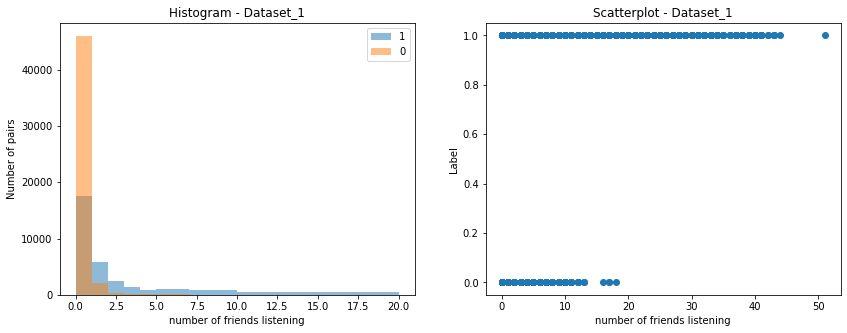

<function matplotlib.pyplot.tight_layout>

In [ ]:
# visualize data for listening counts
plt.figure(figsize=(14, 5)) 

plt.subplot(1,2,1)
bins = [0,1,2,3,4,5,7,10,14,20]
plt.hist(df['FriendsListening'].loc[df['Label'] == 1].values,bins, alpha=0.5, label='1')
plt.hist(df['FriendsListening'].loc[df['Label'] == 0].values,bins, alpha=0.5, label='0')
plt.ylabel('Number of pairs')
plt.xlabel('number of friends listening')
plt.legend(loc='upper right')
plt.title('Histogram - Dataset_1')


plt.subplot(1,2,2)
plt.scatter(df['FriendsListening'].values, df['Label'].values)
plt.xlabel('number of friends listening')
plt.ylabel('Label')
plt.title('Scatterplot - Dataset_1')

plt.show()
plt.tight_layout

In [ ]:
# create X
X2 = np.array(df[['IR','FriendsRating']])
X2.shape

(80137, 2)

In [ ]:
# create y
y = np.array(df['Label'])
y.shape

(80137,)

In [ ]:
# for better visualization
pomocne = np.array(df[['Label','FriendsRating']]).astype(np.float)
for i in range(len(pomocne)):
    if pomocne[i,0] == 1:
       pomocne[i,1] += 0.1

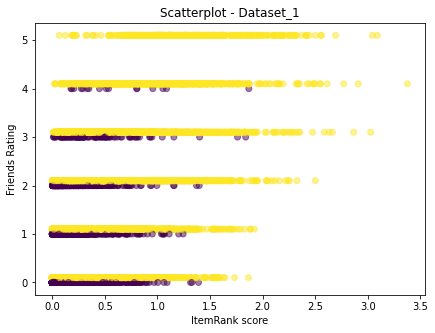

In [ ]:
# visualize them together
plt.figure(figsize=(7, 5)) 
plt.scatter(X2[:, 0], pomocne[:, 1], c=y, alpha=0.5)
plt.xlabel('ItemRank score')
plt.ylabel('Friends Rating')
plt.title('Scatterplot - Dataset_1')
plt.show()

In [ ]:
# divide data into training and test split
X2_train = X2[:65000]
X2_test = X2[65000:]

y_train = y[:65000]
y_test = y[65000:]

print(X2_train.shape)
print(X2_test.shape)
print(y_train.shape)
print(y_test.shape)

(65000, 2)
(15137, 2)
(65000,)
(15137,)


## Logistic Regression

### Model Selection

In [ ]:
C_param_range = [0.001,0.01,0.1,1,10,100]

for c in C_param_range:

    model_LR2 = LogisticRegression(C = c)
    model_LR2.fit(X2_train, y_train)

    model_LR2_mean_score = np.mean(cross_val_score(model_LR2, X2_train, y_train, cv=5))
    print('Mean cross validation score '+str(model_LR2_mean_score ))

Mean cross validation score 0.7460307692307693
Mean cross validation score 0.7646153846153846
Mean cross validation score 0.778676923076923
Mean cross validation score 0.781323076923077
Mean cross validation score 0.781723076923077
Mean cross validation score 0.7817538461538461


In [ ]:
model_LR2 = LogisticRegression()
# Fit model
model_LR2.fit(X2_train, y_train)
print("Traning accuracy for Linear Regression: {}".format(model_LR2.score(X2_train, y_train)))

Traning accuracy for Linear Regression: 0.7838307692307692


### Evaluation

Test accuracy 0.7860210081257845


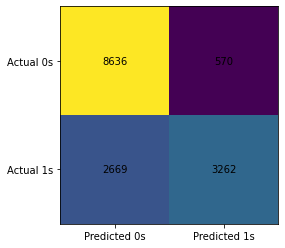

Sensitivity = 0.5499915697184286
Specificity = 0.9380838583532479


In [ ]:
# TEST DATA
# score
print('Test accuracy '+str(model_LR2.score(X2_test, y_test) ))
# confusion matrix
cm = confusion_matrix(y_test, model_LR2.predict(X2_test))
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center')
plt.show()

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, model_LR2.predict(X2_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

In [ ]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
LR2_probs = model_LR2.predict_proba(X2_test)
# keep probabilities for the positive outcome only
LR2_probs = LR2_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
LR2_auc = roc_auc_score(y_test, LR2_probs)
# summarize scores
print('Logistic Regression: ROC AUC = %.3f' % (LR2_auc))

Logistic Regression: ROC AUC = 0.857


## SVC

### Model Selection

In [ ]:
C_input = [0.1,1,10,100]
G_input = [0.01,0.1,'auto',10]
kernel_input = ['rbf', 'linear']
for i in range(len(C_input)):
    for j in range(len(G_input)):
        for k in range(len(kernel_input)):
            svc2 = svm.SVC(C=C_input[i], kernel=kernel_input[k], gamma=G_input[j])
            score = np.mean(cross_val_score(svc2, X2_train, y_train, cv=5))
            print('C:'+ str(C_input[i]) + ', gamma:'+ str(G_input[j]) +', kernel:'+ str(kernel_input[k]) +', score:'+str(score))

C:0.1, gamma:0.01, kernel:rbf, score:0.7503076923076923
C:0.1, gamma:0.01, kernel:linear, score:0.7841230769230769
C:0.1, gamma:0.1, kernel:rbf, score:0.7743384615384615
C:0.1, gamma:0.1, kernel:linear, score:0.7841230769230769
C:0.1, gamma:auto, kernel:rbf, score:0.7854615384615384
C:0.1, gamma:auto, kernel:linear, score:0.7841230769230769
C:0.1, gamma:10, kernel:rbf, score:0.7907230769230769
C:0.1, gamma:10, kernel:linear, score:0.7841230769230769
C:1, gamma:0.01, kernel:rbf, score:0.7740923076923077
C:1, gamma:0.01, kernel:linear, score:0.7857384615384615
C:1, gamma:0.1, kernel:rbf, score:0.7851384615384616
C:1, gamma:0.1, kernel:linear, score:0.7857384615384615
C:1, gamma:auto, kernel:rbf, score:0.7910615384615385
C:1, gamma:auto, kernel:linear, score:0.7857384615384615
C:1, gamma:10, kernel:rbf, score:0.7943230769230769
C:1, gamma:10, kernel:linear, score:0.7857384615384615
C:10, gamma:0.01, kernel:rbf, score:0.7834153846153846
C:10, gamma:0.01, kernel:linear, score:0.785907692307

In [ ]:
C_input = [5,15]
G_input = [5,15]
kernel_input = 'rbf'
for i in range(len(C_input)):
    for j in range(len(G_input)):
            svc2 = svm.SVC(C=C_input[i], kernel=kernel_input, gamma=G_input[j])
            score = np.mean(cross_val_score(svc2, X2_train, y_train, cv=5))
            print('C:'+ str(C_input[i]) + ', gamma:'+ str(G_input[j]) +', score:'+str(score))

C:5, gamma:5, score:0.7924923076923076
C:5, gamma:15, score:0.7974923076923076
C:15, gamma:5, score:0.7939692307692308
C:15, gamma:15, score:0.7977076923076922


In [ ]:
svc2 = svm.SVC(C=5, gamma = 15, kernel='rbf', probability=True)
# fit model
svc2.fit(X2_train, y_train)
print("Traning accuracy for SVC: {}".format(svc2.score(X2_train, y_train)))

Traning accuracy for SVM: 0.7976461538461539


### Evaluation

Testing accuracy for SVC: 0.7969875140384488


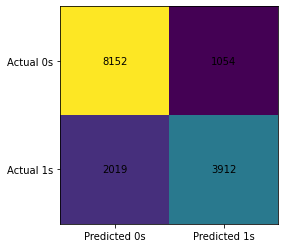

Sensitivity = 0.6595852301466869
Specificity = 0.8855094503584618


In [ ]:
# TEST DATA
# score
print('Testing accuracy for SVC: '+str(svc2.score(X2_test, y_test) ))
# confusion matrix
cm = confusion_matrix(y_test, svc2.predict(X2_test))
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center')
plt.show()

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, svc2.predict(X2_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

In [ ]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
svc2_probs = svc2.predict_proba(X2_test)
# keep probabilities for the positive outcome only
svc2_probs = svc2_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
svc2_auc = roc_auc_score(y_test, svc2_probs)
# summarize scores
print('SVC: ROC AUC = %.3f' % (svc2_auc))

SVC: ROC AUC = 0.829


## Random Forest

### Model Selection

In [ ]:
N_input = [3,10,50,100]
D_input = [1,3,5,10,20,30,40,100]
for i in range(len(N_input)):
    for j in range(len(D_input)):
        rfc = RandomForestClassifier(n_estimators=N_input[i], max_depth=D_input[j])
        score = np.mean(cross_val_score(rfc, X2_train, y_train, cv=5))
        print('# estimators:'+ str(N_input[i]) + ', depth:'+ str(D_input[j]) +', score:'+str(score))

# estimators:3, depth:1, score:0.7628615384615385
# estimators:3, depth:3, score:0.794
# estimators:3, depth:5, score:0.7980307692307692
# estimators:3, depth:10, score:0.7930307692307692
# estimators:3, depth:20, score:0.7699692307692307
# estimators:3, depth:30, score:0.7444769230769231
# estimators:3, depth:40, score:0.7316461538461538
# estimators:3, depth:100, score:0.7192307692307692
# estimators:10, depth:1, score:0.7621692307692308
# estimators:10, depth:3, score:0.7951692307692307
# estimators:10, depth:5, score:0.7983076923076922
# estimators:10, depth:10, score:0.7966923076923077
# estimators:10, depth:20, score:0.7770923076923077
# estimators:10, depth:30, score:0.7457384615384615
# estimators:10, depth:40, score:0.7271692307692308
# estimators:10, depth:100, score:0.7232
# estimators:50, depth:1, score:0.7730615384615385
# estimators:50, depth:3, score:0.7961692307692309
# estimators:50, depth:5, score:0.7981538461538462
# estimators:50, depth:10, score:0.7975230769230769


In [ ]:
N_input = [10,100,200,500]
D_input = [5]
for i in range(len(N_input)):
    for j in range(len(D_input)):
        rfc = RandomForestClassifier(n_estimators=N_input[i], max_depth=D_input[j])
        score = np.mean(cross_val_score(rfc, X2_train, y_train, cv=5))
        print('# estimators:'+ str(N_input[i]) + ', depth:'+ str(D_input[j]) +', score:'+str(score))

# estimators:10, depth:5, score:0.7983538461538461
# estimators:100, depth:5, score:0.7986923076923077
# estimators:200, depth:5, score:0.7985692307692307
# estimators:500, depth:5, score:0.7984769230769231


In [ ]:
rfc2 = RandomForestClassifier(n_estimators=100, max_depth=5)
rfc2.fit(X2_train, y_train)

print("Traning accuracy for Random Forest: {}".format(rfc2.score(X2_train, y_train)))

Traning accuracy for Random Forest: 0.8001538461538461


### Evaluation

Testing accuracy for RFC: 0.7992997291405166


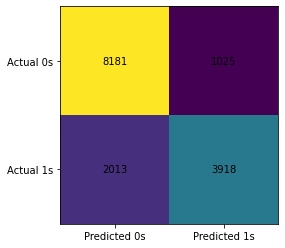

Sensitivity = 0.6605968639352554
Specificity = 0.8886595698457528


In [ ]:
# TEST DATA
# score
print('Testing accuracy for RFC: '+str(rfc2.score(X2_test, y_test) ))
# confusion matrix
cm = confusion_matrix(y_test, rfc2.predict(X2_test))
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center')
plt.show()

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y_test, rfc2.predict(X2_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

In [ ]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
rfc2_probs = rfc2.predict_proba(X2_test)
# keep probabilities for the positive outcome only
rfc2_probs = rfc2_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
rfc2_auc = roc_auc_score(y_test, rfc2_probs)
# summarize scores
print('RFC: ROC AUC = %.3f' % (rfc2_auc))

RFC: ROC AUC = 0.857


## Comparison

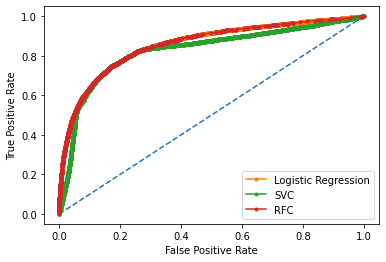

In [ ]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
LR2_fpr, LR2_tpr, _ = roc_curve(y_test, LR2_probs)
rfc2_fpr, rfc2_tpr, _ = roc_curve(y_test, rfc2_probs)
svc2_fpr, svc2_tpr, _ = roc_curve(y_test, svc2_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(LR2_fpr, LR2_tpr, marker='.', label='Logistic Regression')
plt.plot(svc2_fpr, svc2_tpr, marker='.', label='SVC')
plt.plot(rfc2_fpr, rfc2_tpr, marker='.', label='RFC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Approach 3 ( dataset_2 + user friends feature)

In [ ]:
print(len(df2.loc[df2['Label'] == 1]))
print(len(df2.loc[df2['Label'] == 0]))

35768
35662


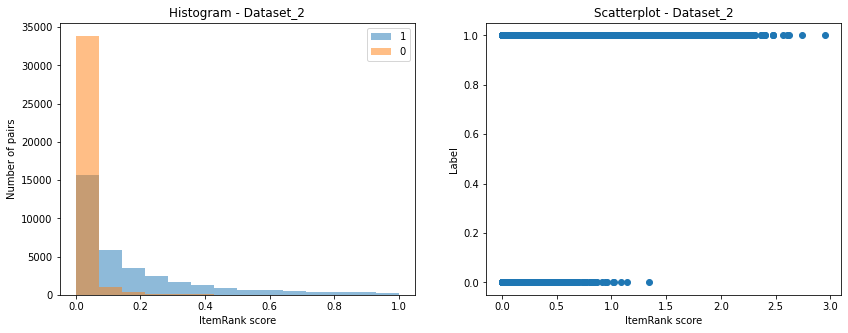

<function matplotlib.pyplot.tight_layout>

In [ ]:
#visualize data 
plt.figure(figsize=(14, 5)) 

plt.subplot(1,2,1)
bins = np.linspace(0, 1, 15)
plt.hist(df2['IR'].loc[df2['Label'] == 1].values,bins, alpha=0.5, label='1')
plt.hist(df2['IR'].loc[df2['Label'] == 0].values,bins, alpha=0.5, label='0')
plt.ylabel('Number of pairs')
plt.xlabel('ItemRank score')
plt.legend(loc='upper right')
plt.title('Histogram - Dataset_2')

plt.subplot(1,2,2)
plt.scatter(df2['IR'].values, df2['Label'].values)
plt.xlabel('ItemRank score')
plt.ylabel('Label')
plt.title('Scatterplot - Dataset_2')

plt.show()
plt.tight_layout

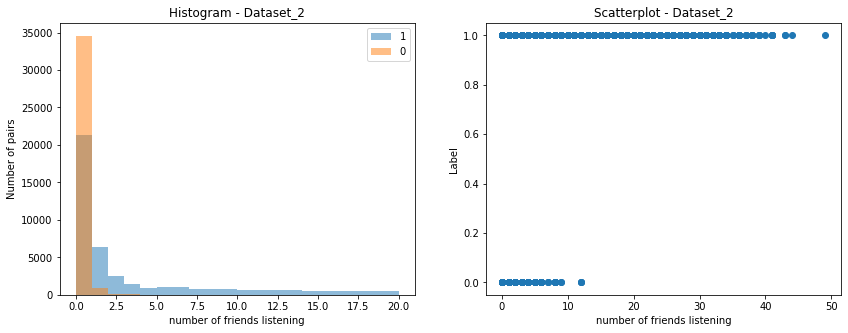

<function matplotlib.pyplot.tight_layout>

In [ ]:
# visualize data for listening counts
plt.figure(figsize=(14, 5)) 

plt.subplot(1,2,1)
bins = [0,1,2,3,4,5,7,10,14,20]
plt.hist(df2['FriendsListening'].loc[df2['Label'] == 1].values,bins, alpha=0.5, label='1')
plt.hist(df2['FriendsListening'].loc[df2['Label'] == 0].values,bins, alpha=0.5, label='0')
plt.ylabel('Number of pairs')
plt.xlabel('number of friends listening')
plt.legend(loc='upper right')
plt.title('Histogram - Dataset_2')

plt.subplot(1,2,2)
plt.scatter(df2['FriendsListening'].values, df2['Label'].values)
plt.xlabel('number of friends listening')
plt.ylabel('Label')
plt.title('Scatterplot - Dataset_2')


plt.show()
plt.tight_layout

In [ ]:
# create X
X3 = np.array(df2[['IR','FriendsRating']])
X3.shape

(71430, 2)

In [ ]:
# create y
y3 = np.array(df2['Label'])
y3.shape

(71430,)

In [ ]:
# for better visualization
pomocne2 = np.array(df2[['Label','FriendsRating']]).astype(np.float)
for i in range(len(pomocne2)):
    if pomocne2[i,0] == 1:
       pomocne2[i,1] += 0.1

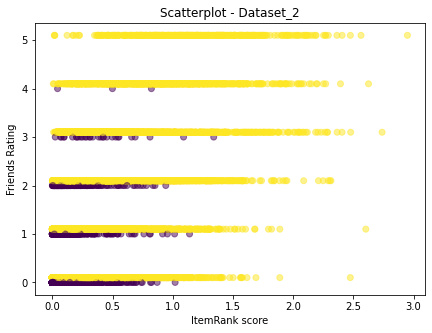

In [ ]:
# visualize them together
plt.figure(figsize=(7, 5)) 
plt.scatter(X3[:, 0], pomocne2[:, 1], c=y3, alpha=0.5)
plt.xlabel('ItemRank score')
plt.ylabel('Friends Rating')
plt.title('Scatterplot - Dataset_2')
plt.show()

In [ ]:
# divide data into training and test split
X3_train = X3[:55000]
X3_test = X3[55000:]

y3_train = y3[:55000]
y3_test = y3[55000:]

print(X3_train.shape)
print(X3_test.shape)
print(y3_train.shape)
print(y3_test.shape)

(55000, 2)
(16430, 2)
(55000,)
(16430,)


## Logistic Regression

### Model Selection

In [ ]:
C_param_range = [0.001,0.01,0.1,1,5,10,100,500]

for c in C_param_range:

    model_LR3 = LogisticRegression(C = c)
    model_LR3.fit(X3_train, y3_train)

    model_LR3_mean_score = np.mean(cross_val_score(model_LR3, X3_train, y3_train, cv=5))
    print('Mean cross validation score '+str(model_LR3_mean_score ))

Mean cross validation score 0.6974545454545454
Mean cross validation score 0.7427999999999999
Mean cross validation score 0.7788
Mean cross validation score 0.7911818181818182
Mean cross validation score 0.7930363636363637
Mean cross validation score 0.7933636363636364
Mean cross validation score 0.7935818181818182
Mean cross validation score 0.7935636363636365


In [ ]:
model_LR3 = LogisticRegression()
# Fit model
model_LR3.fit(X3_train, y3_train)
print("Traning accuracy for Linear Regression: {}".format(model_LR3.score(X3_train, y3_train)))

Traning accuracy for Linear Regression: 0.7915090909090909


### Evaluation

Testing accuracy 0.7867315885575168


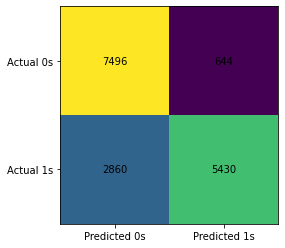

Sensitivity = 0.6550060313630881
Specificity = 0.9208845208845209


In [ ]:
# TEST DATA
# score
print('Testing accuracy '+str(model_LR3.score(X3_test, y3_test) ))
# confusion matrix
cm = confusion_matrix(y3_test, model_LR3.predict(X3_test))
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center')
plt.show()

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y3_test, model_LR3.predict(X3_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

In [ ]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y3_test))]
# predict probabilities
LR3_probs = model_LR3.predict_proba(X3_test)
# keep probabilities for the positive outcome only
LR3_probs = LR3_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y3_test, ns_probs)
LR3_auc = roc_auc_score(y3_test, LR3_probs)
# summarize scores
print('Logistic Regression: ROC AUC = %.3f' % (LR3_auc))

Logistic Regression: ROC AUC = 0.877


## SVC

### Model Selection

In [ ]:
C_input = [0.1,1,10,100]
G_input = [0.01,0.1,'auto',1,10]
kernel_input = ['rbf', 'linear']
for i in range(len(C_input)):
    for j in range(len(G_input)):
        for k in range(len(kernel_input)):
            svc3 = svm.SVC(C=C_input[i], kernel=kernel_input[k], gamma=G_input[j])
            score = np.mean(cross_val_score(svc3, X3_train, y3_train, cv=5))
            print('C:'+ str(C_input[i]) + ', gamma:'+ str(G_input[j]) +', kernel:'+ str(kernel_input[k]) +', score:'+str(score))

C:0.1, gamma:0.01, kernel:rbf, score:0.6978909090909091
C:0.1, gamma:0.01, kernel:linear, score:0.7780727272727272
C:0.1, gamma:0.1, kernel:rbf, score:0.7533454545454547
C:0.1, gamma:0.1, kernel:linear, score:0.7780727272727272
C:0.1, gamma:auto, kernel:rbf, score:0.7818363636363637
C:0.1, gamma:auto, kernel:linear, score:0.7780727272727272
C:0.1, gamma:1, kernel:rbf, score:0.7897272727272727
C:0.1, gamma:1, kernel:linear, score:0.7780727272727272
C:0.1, gamma:10, kernel:rbf, score:0.8068181818181819
C:0.1, gamma:10, kernel:linear, score:0.7780727272727272
C:1, gamma:0.01, kernel:rbf, score:0.752490909090909
C:1, gamma:0.01, kernel:linear, score:0.7910909090909091
C:1, gamma:0.1, kernel:rbf, score:0.7860363636363636
C:1, gamma:0.1, kernel:linear, score:0.7910909090909091
C:1, gamma:auto, kernel:rbf, score:0.7970181818181818
C:1, gamma:auto, kernel:linear, score:0.7910909090909091
C:1, gamma:1, kernel:rbf, score:0.8006
C:1, gamma:1, kernel:linear, score:0.7910909090909091
C:1, gamma:10,

In [ ]:
svc3 = svm.SVC(C=1, gamma = 10, kernel='rbf', probability=True)
# fit model
svc3.fit(X3_train, y3_train)
print("Traning accuracy for SVC: {}".format(svc3.score(X3_train, y3_train)))

Traning accuracy for SVC: 0.811509090909091


### Evaluation



Testing accuracy for SVC: 0.8035301278149726


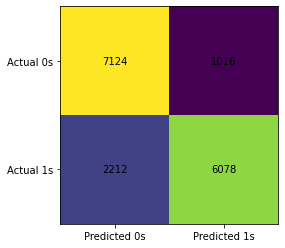

Sensitivity = 0.7331724969843184
Specificity = 0.8751842751842752


In [ ]:
# TEST DATA
# score
print('Testing accuracy for SVC: '+str(svc3.score(X3_test, y3_test) ))
# confusion matrix
cm = confusion_matrix(y3_test, svc3.predict(X3_test))
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center')
plt.show()

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y3_test, svc3.predict(X3_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

In [ ]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y3_test))]
# predict probabilities
svc3_probs = svc3.predict_proba(X3_test)
# keep probabilities for the positive outcome only
svc3_probs = svc3_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y3_test, ns_probs)
svc3_auc = roc_auc_score(y3_test, svc3_probs)
# summarize scores
print('SVC: ROC AUC = %.3f' % (svc3_auc))

SVC: ROC AUC = 0.863


## Random Forest

### Model selection

In [ ]:
N_input = [3,10,50,100,500]
D_input = [1,3,5,10,20,40,100]
for i in range(len(N_input)):
    for j in range(len(D_input)):
        rfc3 = RandomForestClassifier(n_estimators=N_input[i], max_depth=D_input[j])
        score = np.mean(cross_val_score(rfc3, X3_train, y3_train, cv=5))
        print('# estimators:'+ str(N_input[i]) + ', depth:'+ str(D_input[j]) +', score:'+str(score))

# estimators:3, depth:1, score:0.8082545454545456
# estimators:3, depth:3, score:0.8146727272727272
# estimators:3, depth:5, score:0.8148545454545454
# estimators:3, depth:10, score:0.8113636363636363
# estimators:3, depth:20, score:0.7858181818181817
# estimators:3, depth:40, score:0.7507454545454546
# estimators:3, depth:100, score:0.7437090909090909
# estimators:10, depth:1, score:0.8153818181818181
# estimators:10, depth:3, score:0.8147272727272729
# estimators:10, depth:5, score:0.8150909090909091
# estimators:10, depth:10, score:0.8137090909090908
# estimators:10, depth:20, score:0.7918181818181818
# estimators:10, depth:40, score:0.7470363636363636
# estimators:10, depth:100, score:0.7445818181818181
# estimators:50, depth:1, score:0.8138727272727273
# estimators:50, depth:3, score:0.8151272727272728
# estimators:50, depth:5, score:0.8151636363636363
# estimators:50, depth:10, score:0.8141636363636364
# estimators:50, depth:20, score:0.7959636363636363
# estimators:50, depth:40,

In [ ]:
N_input = [100]
D_input = [1,2,3,4,5,6]
for i in range(len(N_input)):
    for j in range(len(D_input)):
        rfc3 = RandomForestClassifier(n_estimators=N_input[i], max_depth=D_input[j])
        score = np.mean(cross_val_score(rfc3, X3_train, y3_train, cv=5))
        print('# estimators:'+ str(N_input[i]) + ', depth:'+ str(D_input[j]) +', score:'+str(score))

# estimators:100, depth:1, score:0.8150727272727274
# estimators:100, depth:2, score:0.8151636363636363
# estimators:100, depth:3, score:0.8151090909090909
# estimators:100, depth:4, score:0.815218181818182
# estimators:100, depth:5, score:0.8150545454545455
# estimators:100, depth:6, score:0.8149272727272727


In [ ]:
rfc3 = RandomForestClassifier(n_estimators=100, max_depth=4)
rfc3.fit(X3_train, y3_train)

print("Traning accuracy for Random Forest: {}".format(rfc3.score(X3_train, y3_train)))

Traning accuracy for Random Forest: 0.8154727272727272


### Evaluation

Testing accuracy for RFC: 0.8075471698113208


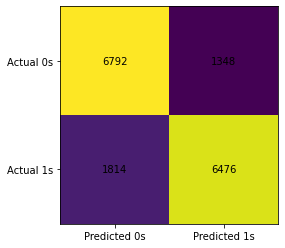

Sensitivity = 0.7811821471652594
Specificity = 0.8343980343980344


In [ ]:
# TEST DATA
# score
print('Testing accuracy for RFC: '+str(rfc3.score(X3_test, y3_test) ))
# confusion matrix
cm = confusion_matrix(y3_test, rfc3.predict(X3_test))
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center')
plt.show()

# Specificity and sensitivity
tn, fp, fn, tp = confusion_matrix(y3_test, rfc3.predict(X3_test)).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity = '+str(sensitivity))
print('Specificity = '+str(specificity))

In [ ]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y3_test))]
# predict probabilities
rfc3_probs = rfc3.predict_proba(X3_test)
# keep probabilities for the positive outcome only
rfc3_probs = rfc3_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y3_test, ns_probs)
rfc3_auc = roc_auc_score(y3_test, rfc3_probs)
# summarize scores
print('RFC: ROC AUC = %.3f' % (rfc3_auc))

RFC: ROC AUC = 0.877


## Comparison

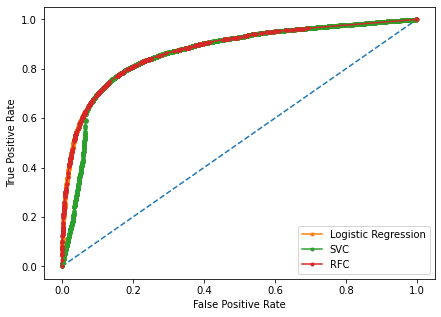

In [ ]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y3_test, ns_probs)
LR3_fpr, LR3_tpr, _ = roc_curve(y3_test, LR3_probs)
rfc3_fpr, rfc3_tpr, _ = roc_curve(y3_test, rfc3_probs)
svc3_fpr, svc3_tpr, _ = roc_curve(y3_test, svc3_probs)
# plot the roc curve for the model
plt.figure(figsize=(7, 5)) 
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(LR3_fpr, LR3_tpr, marker='.', label='Logistic Regression')
plt.plot(svc3_fpr, svc3_tpr, marker='.', label='SVC')
plt.plot(rfc3_fpr, rfc3_tpr, marker='.', label='RFC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Threshold experiments

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class CustomThreshold(BaseEstimator, ClassifierMixin):
    """ Custom threshold wrapper for binary classification"""
    def __init__(self, base, threshold=0.5):
        self.base = base
        self.threshold = threshold
    def fit(self, *args, **kwargs):
        self.base.fit(*args, **kwargs)
        return self
    def predict(self, X):
        return (self.base.predict_proba(X)[:, 1] > self.threshold).astype(int)    

In [ ]:
clf = [CustomThreshold(model_LR3, threshold) for threshold in [0.5, 0.6, 0.7]] 

In [ ]:
for model in clf:
    print(confusion_matrix(y3_test, model.predict(X3_test)))

    tn, fp, fn, tp = confusion_matrix(y3_test, model.predict(X3_test)).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    accuracy = (tp + tn) / (tp+tn+fp+fn)
    print('Sensitivity = '+str(sensitivity))
    print('Specificity = '+str(specificity))
    print('Accuracy= '+str(accuracy))

[[7496  644]
 [2860 5430]]
Sensitivity = 0.6550060313630881
Specificity = 0.9208845208845209
Accuracy= 0.7867315885575168
[[7675  465]
 [3307 4983]]
Sensitivity = 0.6010856453558504
Specificity = 0.9428746928746928
Accuracy= 0.7704199634814364
[[7807  333]
 [3770 4520]]
Sensitivity = 0.5452352231604343
Specificity = 0.9590909090909091
Accuracy= 0.7502738892270238


In [ ]:
clf2 = [CustomThreshold(rfc3, threshold) for threshold in [0.7, 0.8, 0.8]] 

In [ ]:
for model in clf2:
    print(confusion_matrix(y3_test, model.predict(X3_test)))

    tn, fp, fn, tp = confusion_matrix(y3_test, model.predict(X3_test)).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    accuracy = (tp + tn) / (tp+tn+fp+fn)
    print('Sensitivity = '+str(sensitivity))
    print('Specificity = '+str(specificity))
    print('Accuracy= '+str(accuracy))

[[7476  664]
 [2794 5496]]
Sensitivity = 0.6629674306393245
Specificity = 0.9184275184275185
Accuracy= 0.789531345100426
[[7753  387]
 [3597 4693]]
Sensitivity = 0.5661037394451146
Specificity = 0.9524570024570025
Accuracy= 0.7575167376749847
[[7753  387]
 [3597 4693]]
Sensitivity = 0.5661037394451146
Specificity = 0.9524570024570025
Accuracy= 0.7575167376749847
